# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os.path import join
import json
import datetime

import shap
from shap_selection import feature_selection

from sklearn.preprocessing import OneHotEncoder
import time

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [4]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams
from src.plots.functions import plot_3d_surface, plot_2d_surface, boxplot_stability, lineplot_stability
from src.utils.functions import add_custom_repeating_sequence, add_sequence_to_dataframe, prepare_subsets
from src.optimization.functions import opt_value

# if we want to create an iteractive plot or not
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

## Arrhythmia

**Dataset source**: http://odds.cs.stonybrook.edu/arrhythmia-dataset/ (data is transformed from .mat to .csv format)

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Additional sources**:

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. “Isolation forest.” 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.

K. M. Ting, J. T. S. Chuan, and F. T. Liu. “Mass: A New Ranking Measure for Anomaly Detection.“, IEEE Transactions on Knowledge and Data Engineering, 2009.

F. Keller, E. Muller, K. Bohm.“HiCS: High-contrast subspaces for density-based outlier ranking.” ICDE, 2012.

In [5]:
dataset_id = 'arrhythmia'

data = get_fs_dataset(dataset_id, data_root)
hyper = fs_datasets_hyperparams(dataset_id)
data.shape

(452, 275)

In [6]:
pd.pivot_table(data,
             values = 'Col1',
               index = 'y', 
              aggfunc = 'count')

,Col1
y,
0,386
1,66


In [7]:
excluded_cols = ['Col15', 'Col63', 'Col65', 'Col79', 'Col127', 'Col128','Col135', 'Col137', 'Col139','Col141','Col147', 'Col152', 'Col153', 'Col160', 'Col200', 'Col260', 'Col270']

### iForest

## Parameters

In [8]:
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")
df = pd.read_parquet(path_shap)

image_1 = os.path.join(data_root, "images", f'3d_precision_{dataset_id}.png')
image_2 = os.path.join(data_root, "images", f'3d_shap_index_{dataset_id}.png')
image_3 = os.path.join(data_root, "images", f'2d_precision_stability_{dataset_id}.png')
image_4 = os.path.join(data_root, "images", f'2d_boxplots_{dataset_id}.png')
image_5 = os.path.join(data_root, "images", f'2d_lineplots_{dataset_id}.png')
image_6 = os.path.join(data_root, "images", f'3d_precision_stability_{dataset_id}.png')

In [9]:
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

fi_shap_all = pd.read_parquet(path_fi_shap)
df = pd.read_parquet(path_shap)
df = df[(df.n_estimators>=25) & (df.n_estimators<=600)]

df['shap_q1'] = df['shap_stab'].apply(lambda x: np.percentile(x, 75))
df['shap_q2'] = df['shap_stab'].apply(lambda x: np.percentile(x, 50))
df['shap_q3'] = df['shap_stab'].apply(lambda x: np.percentile(x, 25))

df['shap_ad_q2'] = df['shap_stab_ad'].apply(lambda x: np.percentile(x, 50))
df['stability index'] = df['shap_stab'].apply(lambda x: np.mean(x))

var = ['n_estimators', 'max_feats', 'n_feats', 'f1_median', 'precision', 'recall', 'model_stab', 'shap_stab', 'shap_q2', 'stability index', 'roc_auc']
df = df[var]

## Optimization

In [10]:
sorted_df = opt_value(df, lambda_=0.7, var2='stability index')

opt_x = int(sorted_df.iloc[0:1,:].n_estimators)
opt_y = int(sorted_df.iloc[0:1,:].n_feats)

sorted_df.head(5)

,n_estimators,max_feats,n_feats,f1_median,precision,recall,model_stab,shap_stab,shap_q2,stability index,roc_auc,opt_value
2398,500,75,94,0.565217,0.650000,0.5,0.992174,"[0.925741059924873, 0.8337315568032532, 0.8596...",0.856642,0.852592,0.809926,0.710778
2343,475,75,94,0.565217,0.650000,0.5,0.992040,"[0.9247727953026743, 0.827049142125321, 0.8579...",0.850535,0.848847,0.810670,0.709654
2178,400,75,94,0.565217,0.650000,0.5,0.991063,"[0.9123544847154558, 0.8098776505170049, 0.855...",0.841157,0.838836,0.808933,0.706651
2344,475,94,94,0.553191,0.619048,0.5,0.990055,"[0.9290404445510998, 0.8366020195253386, 0.845...",0.846674,0.848372,0.809181,0.687845
2288,450,75,94,0.553191,0.619048,0.5,0.991981,"[0.9223249390069794, 0.8284382442047586, 0.854...",0.848985,0.847179,0.811414,0.687487


## Visualization of the results

In [11]:
# Find the index of the maximum 'n_feat' in each 'n_estimators' and 'n_feats' group
idx = df.groupby(['n_estimators', 'n_feats'])['max_feats'].idxmax()
# Filter the DataFrame to keep only the rows with the maximum 'n_feat' per group
df_n_trees = df.loc[idx].reset_index(drop=True)

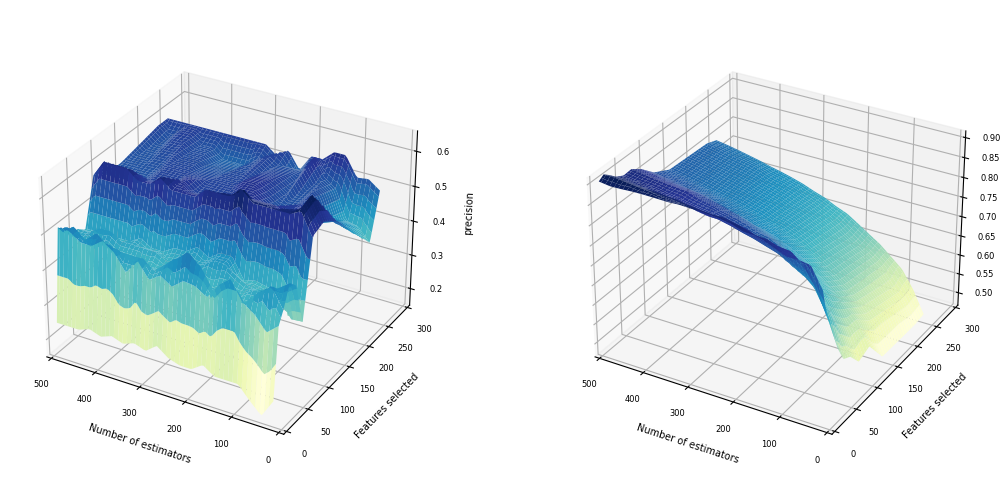

In [12]:
plt.figure(figsize=(10, 5))  # Overall figure size

# First plot
ax1 = plt.subplot(1, 2, 1, projection='3d')
plot_3d_surface(df_n_trees, 'n_estimators', 'n_feats', 'precision', ax1, fontsize_title=7, fontsize_axes=6, cmap='YlGnBu', x_step=100, y_step=50, opt_color='red', title='')

ax2 = plt.subplot(1, 2, 2, projection='3d')
plot_3d_surface(df_n_trees, 'n_estimators', 'n_feats', 'stability index', ax2, fontsize_title=7, fontsize_axes=6, cmap='YlGnBu', x_step=100, y_step=50, opt_color='red')

plt.tight_layout()  # Adjust layout

# Adjust the spacing between the plots
plt.subplots_adjust(wspace=0.3)  # Adjust the width space as needed for better visualization

plt.savefig(image_6, bbox_inches='tight', pad_inches=0.1)  # Save the plot to a file
plt.show()

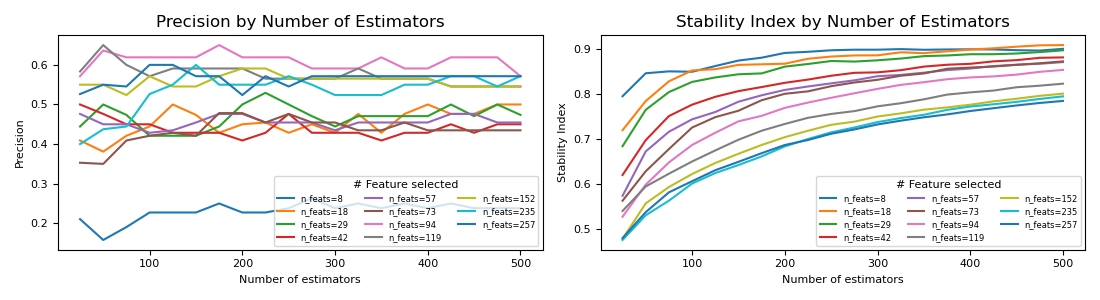

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))  # 1 row, 2 columns

plot_2d_surface(df_n_trees, axs, fontsize_title=12, fontsize_axes=8, save_path=image_3)

In [14]:
# Sorting the DataFrame
df = df.sort_values(by=['n_estimators', 'n_feats', 'max_feats'], ascending=[True, False, False])

# Adding sequences
df = add_custom_repeating_sequence(df, 'rank_max_feats', 5)
sequence = np.concatenate([np.repeat(i, 5) for i in range(1, 12)])  # Creating a sequence from 1 to 11, each repeating 5 times
df = add_sequence_to_dataframe(df, sequence, 'rank_feats')

# Assigning rank based on group
df['rank_estimators'] = df.groupby(['n_feats', 'rank_max_feats']).cumcount() + 1

# Preparing subsets
ranks = [1, 2, 4, 6, 8, 10]  # Define ranks of interest
max_feats = [1, 2, 3, 4, 5]  # Define max_feats of interest
subsets = prepare_subsets(df, ranks, max_feats)

# Now, you can access your subsets like subsets['df1_1'], subsets['df2_1'], ..., subsets['df10_1'].

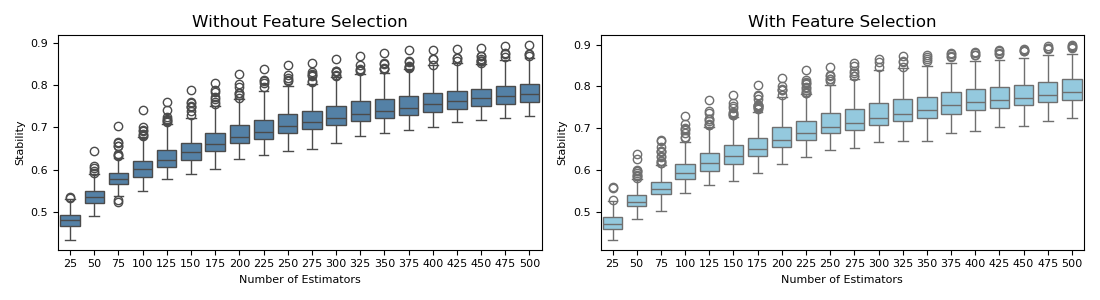

In [15]:
# Define your DataFrame for without feature selection `df0` and with feature selection `df1`
fig, axs = plt.subplots(1, 2, figsize=(11, 3))  # Create a figure and a 2x1 grid of subplots

# Call the boxplot_stability function
boxplot_stability(subsets['df1_1'], subsets['df2_1'], axs, fontsize_title=12, fontsize_axes=8, title='Comparison of SHAP Stability', save_path=image_4)

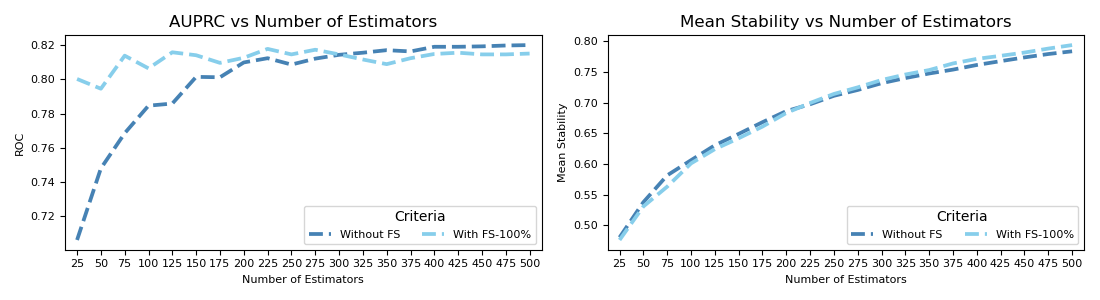

In [16]:
dataframes = [subsets['df1_1'], subsets['df2_1']] #, df21, df31, df41, df51

fig, axs = plt.subplots(1, 2, figsize=(11, 3))  # Create a figure and a 2x1 grid of subplots

# Assume `dataframes` is a list of DataFrame objects you want to plot
# Call the lineplot_stability function
lineplot_stability(dataframes, axs, fontsize_title=12, fontsize_axes=8, save_path=image_5)


In [30]:
df_compare = subsets['df1_1']
df_compare = df_compare[(df_compare.n_estimators==100) & (df_compare.n_feats==257) & (df_compare.max_feats==257)]
roc = df_compare.roc_auc
precision = df_compare.precision
recall = df_compare.recall
f1_median = df_compare.f1_median
var = ['n_estimators', 'n_feats', 'max_feats', 'roc_auc', 'precision', 'recall', 'f1_median', 'stability index']
df_result = df_compare[var].drop_duplicates()
roc = df_result.roc_auc[0]
precision = df_result.precision[0]
recall = df_result.recall[0]
f1_median = df_result.f1_median[0]
df_result

,n_estimators,n_feats,max_feats,roc_auc,precision,recall,f1_median,stability index
1539,100,257,257,0.784615,0.6,0.461538,0.521739,0.606028


In [40]:
df[
(df.roc_auc >= float(roc)) &
(df.precision >= float(precision)) & 
(df.recall >= int(recall)) & 
(df.f1_median>=int(f1_median))
].sort_values('stability index', ascending=False)

,n_estimators,max_feats,n_feats,f1_median,precision,recall,model_stab,shap_stab,shap_q2,stability index,roc_auc,opt_value,rank_max_feats,rank_feats,rank_estimators
2398,500,75,94,0.565217,0.650000,0.500000,0.992174,"[0.925741059924873, 0.8337315568032532, 0.8596...",0.856642,0.852592,0.809926,0.710778,2,5,20
2343,475,75,94,0.565217,0.650000,0.500000,0.992040,"[0.9247727953026743, 0.827049142125321, 0.8579...",0.850535,0.848847,0.810670,0.709654,2,5,19
2344,475,94,94,0.553191,0.619048,0.500000,0.990055,"[0.9290404445510998, 0.8366020195253386, 0.845...",0.846674,0.848372,0.809181,0.687845,1,5,19
2288,450,75,94,0.553191,0.619048,0.500000,0.991981,"[0.9223249390069794, 0.8284382442047586, 0.854...",0.848985,0.847179,0.811414,0.687487,2,5,18
2233,425,75,94,0.553191,0.619048,0.500000,0.991531,"[0.9173661596451126, 0.8214363482029212, 0.851...",0.844878,0.842754,0.809677,0.686160,2,5,17
2289,450,94,94,0.553191,0.619048,0.500000,0.989998,"[0.928333498503605, 0.830989019701136, 0.83418...",0.837862,0.842197,0.809677,0.685993,1,5,18
2178,400,75,94,0.565217,0.650000,0.500000,0.991063,"[0.9123544847154558, 0.8098776505170049, 0.855...",0.841157,0.838836,0.808933,0.706651,2,5,16
2234,425,94,94,0.553191,0.619048,0.500000,0.989659,"[0.9249656958767691, 0.8248027240515777, 0.827...",0.837024,0.838268,0.809926,0.684814,1,5,17
2123,375,75,94,0.553191,0.619048,0.500000,0.990668,"[0.9078937984150898, 0.8007749526818516, 0.845...",0.834167,0.833070,0.809926,0.683254,2,5,15
2068,350,75,94,0.553191,0.619048,0.500000,0.990313,"[0.9031470767509265, 0.7816082433721068, 0.843...",0.825379,0.825813,0.811663,0.681077,2,5,14
